In [17]:
import pickle
import torch
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

In [18]:
data_path = Path("/home/ubuntu/bfs/jj/ThunderKittens/demos/kvm-runner/smid.pkl")

with open(data_path, "rb") as f:
    data = pickle.load(f)


In [19]:
timings = data["timings"]
instructions = data["instructions"]
python_instructions = data["python_instructions"]

timings.shape, instructions.shape

(torch.Size([148, 64, 128]), torch.Size([148, 64, 32]))

In [20]:
NUM_SMS, NUM_INSTRUCTIONS, _ = timings.shape

In [21]:
# // timing event convention
# constexpr int TEVENT_CONTROLLER_START = 0;
# constexpr int TEVENT_IFETCH_DONE = 1;
# constexpr int TEVENT_PAGE_ALLOC_DONE = 2;
# constexpr int TEVENT_SEMS_SETUP = 3;
# constexpr int TEVENT_CONTROLLER_END = 4;
# constexpr int TEVENT_LOADER_START = 5;
# constexpr int TEVENT_LAUNCHER_START = 7;
# constexpr int TEVENT_STORER_START = 9;
# // need NUM_CONSUMER_WARPS * 2 slots here
# constexpr int TEVENT_CONSUMER_START = 11;

# constexpr int TEVENT_AT_GMEM_WAIT = 44;
# constexpr int TEVENT_DONE_GMEM_WAIT = 45;

# constexpr int TEVENT_OUTPUT_READY = 46;

# constexpr int FREE_SLOTS_START = 47;

# constexpr int TEVENT_TRIPLES_START = 100;
# constexpr int TEVENT_TRIPLES_END = 110;
# constexpr int TEVENT_TRIPLES_STORE_START = 124;
# constexpr int TEVENT_TRIPLES_OUTPUT_READY = 125;

TEVENT_CONTROLLER_START = 0
TEVENT_IFETCH_DONE = 1
TEVENT_PAGE_ALLOC_DONE = 2
TEVENT_SEMS_SETUP = 3
TEVENT_CONTROLLER_END = 4
TEVENT_LOADER_START = 5
TEVENT_LOADER_END = 6
TEVENT_LAUNCHER_START = 7
TEVENT_LAUNCHER_END = 8
TEVENT_STORER_START = 9
TEVENT_STORER_END = 10
TEVENT_CONSUMER_START = 11
TEVENT_CONSUMER_END = 12
TEVENT_AT_GMEM_WAIT = 44
TEVENT_DONE_GMEM_WAIT = 45

CLOCK_SPEED = 1.8e9


OPCODE_RMS_QKV_MatVecRopeAppend = 1
OPCODE_PartialAttention = 2
OPCODE_AttentionReduction = 3
OPCODE_O_ProjResidual = 4
OPCODE_RMS_DoubleMatVecSiLU = 5
OPCODE_DownProjResidual = 6
OPCODE_LM_Head = 7


In [14]:
# determine total time spent in each op

op_to_total_time = defaultdict(int)

for sm in range(NUM_SMS):
    for i in range(NUM_INSTRUCTIONS):
        opcode = instructions[sm, i, 0].item()
        start = timings[sm, i, TEVENT_CONTROLLER_START].item()
        end = timings[sm, i, TEVENT_CONTROLLER_END].item()
        elapsed = end - start
        assert elapsed > 0
        op_to_total_time[opcode] += end - start

total_time = sum(op_to_total_time.values())
relative_time = {k: v / total_time for k, v in op_to_total_time.items()}

relative_time

{1: 0.17461938438973687,
 2: 0.010525662642809009,
 5: 0.27398112648486306,
 6: 0.32256883162326894,
 4: 0.10748042194378887,
 7: 0.08687031443688276,
 0: 0.023954258478650528}

In [15]:
max_per_sm = timings.max(-1).values.max(-1).values
total_max = max_per_sm.max()
relative_finishes = max_per_sm / total_max

relative_finishes.min()

tensor(0.8525)

In [16]:
relative_finishes

tensor([0.8867, 0.8534, 0.9246, 0.8939, 0.9496, 0.9316, 0.9977, 0.9652, 0.9685,
        0.9427, 0.9849, 0.9617, 0.9772, 0.9519, 0.9382, 0.9317, 0.8824, 0.8525,
        0.9318, 0.9082, 0.9685, 0.9329, 0.9876, 0.9629, 0.9758, 0.9246, 0.9759,
        0.9459, 0.9753, 0.9464, 0.9582, 0.9407, 0.8988, 0.8655, 0.9528, 0.9175,
        0.9591, 0.9253, 0.9710, 0.9429, 0.9371, 0.9199, 0.9820, 0.9624, 0.9864,
        0.9612, 0.9721, 0.9402, 0.8948, 0.8525, 0.9467, 0.9122, 0.9468, 0.9193,
        0.9800, 0.9663, 0.9828, 0.9580, 0.9975, 0.9654, 0.9447, 0.9296, 0.9311,
        0.9326, 0.8850, 0.8551, 0.9205, 0.9113, 0.9602, 0.9270, 0.9922, 0.9652,
        0.9778, 0.9278, 0.9837, 0.9390, 0.9852, 0.9522, 0.9279, 0.9186, 0.9557,
        0.9258, 0.9696, 0.9402, 1.0000, 0.9660, 0.9727, 0.9427, 0.9828, 0.9623,
        0.9156, 0.9049, 0.9655, 0.9363, 0.9233, 0.9085, 0.9692, 0.9390, 0.9948,
        0.9425, 0.9785, 0.9301, 0.9503, 0.9287, 0.9882, 0.9637, 0.9657, 0.9421,
        0.9420, 0.9024, 0.9547, 0.9171, 

In [13]:
max_clocks = timings.max()
max_time = max_clocks / CLOCK_SPEED * 1e6

min_frac = relative_finishes.min()
min_time = max_time * min_frac

min_time, max_time

(tensor(521.8661), tensor(679.1028))

(array([ 45., 153., 230., 225., 110.,  64., 184., 324., 427., 410., 252.,
        195., 180., 179., 191., 232., 202., 198., 222., 142.,  53.,  46.,
        105., 156., 168., 112.,  69.,  43.,  37.,  58., 215., 401., 401.,
        335., 292., 401., 356., 222., 168., 258., 353., 298., 130.,  63.,
         33.,  15.,   5.,   1.,   1.,   1.,   5.,   3.,  14.,  15.,   9.,
         11.,  11.,   8.,   5.,   1.,   3.,   7.,   8.,  13.,   3.,   5.,
          2.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          3.,   6.,  11.,   5.,   9.,   7.,  14.,   9.,   9.,   6.,  12.,
         10.,   8.,   3.,   7.,  10.,  12.,  10.,  15.,  10.,  12.,   0.,
          2.]),
 array([ 5.35166667,  5.66267778,  5.97368889,  6.2847    ,  6.59571111,
         6.90672222,  7.21773333,  7.52874444,  7.83975556,  8.15076667,
         8.46177778,  8.77278889,  9.0838    ,  9.39481111,  9.70582222,
        10.01683333, 10.32784444, 10.63885556, 10.94986667, 11.26087778,
        11.57188889, 11.88

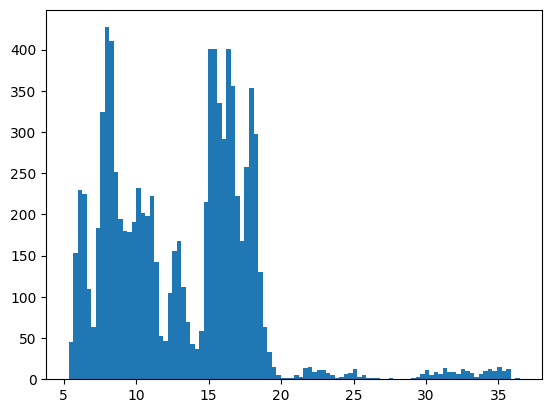

In [31]:
gmem_wait_times = []
for sm in range(NUM_SMS):
    for i in range(NUM_INSTRUCTIONS):
        opcode = instructions[sm, i, 0].item()
        if opcode in [0,7]:
            continue

        gmem_start = timings[sm, i, TEVENT_STORER_START].item()
        gmem_end = timings[sm, i, TEVENT_STORER_END].item()
        elapsed = gmem_end - gmem_start

        gmem_wait_times.append(elapsed)


gmem_wait_times_us = [x / CLOCK_SPEED * 1e6 for x in gmem_wait_times]

plt.hist(gmem_wait_times_us, bins=100)


In [27]:
sum(x for x in gmem_wait_times_us if x > 0) / 148 / 64

11.499551661036035

In [10]:
timings[
    0,
    :20,
    torch.tensor(
        [
            TEVENT_CONTROLLER_START,
            TEVENT_IFETCH_DONE,
            TEVENT_PAGE_ALLOC_DONE,
            TEVENT_SEMS_SETUP,
            TEVENT_CONTROLLER_END,
        ]
    ),
]

tensor([[ 8628,  9341,  9673, 10378, 16562],
        [10568, 11095, 12792, 12940, 18509],
        [13259, 13787, 14226, 14371, 20492],
        [14819, 15345, 15623, 15866, 22381],
        [16777, 17302, 17597, 17753, 24396],
        [18737, 19249, 19489, 19645, 26328],
        [20749, 21279, 21524, 21672, 28384],
        [22699, 23295, 23528, 23673, 30544],
        [24817, 25360, 25593, 25740, 32677],
        [26740, 27390, 27636, 27782, 34783],
        [28891, 29560, 29800, 29951, 36875],
        [30952, 31686, 31924, 32069, 38964],
        [33190, 33790, 34047, 34193, 41052],
        [35252, 35889, 36135, 36284, 43125],
        [37386, 37984, 38222, 38374, 45223],
        [39447, 40036, 40314, 40460, 47284],
        [41545, 42114, 42376, 42521, 49370],
        [43602, 44195, 44460, 44610, 51423],
        [45675, 46267, 46515, 46662, 53432],
        [47740, 48386, 48623, 48773, 55474]], dtype=torch.int32)

In [8]:
timings[0, :10, torch.tensor([TEVENT_CONTROLLER_START, TEVENT_LOADER_START, TEVENT_LOADER_END, TEVENT_CONTROLLER_END])]

tensor([[ 8628,     0,     0, 16562],
        [10568,     0,     0, 18509],
        [13259,     0,     0, 20492],
        [14819,     0,     0, 22381],
        [16777,     0,     0, 24396],
        [18737,     0,     0, 26328],
        [20749,     0,     0, 28384],
        [22699,     0,     0, 30544],
        [24817,     0,     0, 32677],
        [26740,     0,     0, 34783]], dtype=torch.int32)

In [55]:
tensor_instructions[0, :20, 0]

tensor([1, 1, 4, 5, 5, 5, 6, 6, 6, 6, 1, 4, 5, 5, 5, 5, 6, 6, 6, 1],
       dtype=torch.int32)

In [48]:
timings[0, :10, torch.tensor([TEVENT_AT_GMEM_WAIT, TEVENT_DONE_GMEM_WAIT, TEVENT_STORE_START, TEVENT_STORE_END, TEVENT_CONTROLLER_START, TEVENT_CONTROLLER_END])]

tensor([[ 20543,  20611,  14818,  52812,  10641,  57691],
        [ 58340,  58408,  56920,  76516,  14944,  82056],
        [ 68689, 105852,  80980, 119069,  58200, 120351],
        [113960, 121907, 120225, 151790,  82434, 153005],
        [142075, 142647, 152882, 172708, 120718, 173620],
        [164966, 165611, 173221, 191788, 154728, 192720],
        [185464, 214865, 192248, 225671, 174035, 226781],
        [222491, 223044, 226599, 232725, 193087, 233690],
        [233435, 234005, 233585, 243643, 227493, 244854],
        [241520, 242116, 244729, 250707, 234061, 252124]], dtype=torch.int32)

In [54]:
timings[0, :20, torch.tensor([TEVENT_CONTROLLER_START, TEVENT_SEMS_SETUP, TEVENT_LOADER_START, TEVENT_LOADER_END, TEVENT_CONTROLLER_END])]

tensor([[ 10641,  13795,  16376,  25035,  57691],
        [ 14944,  24406,  32385,  59626,  82056],
        [ 58200,  63795,  66285, 107098, 120351],
        [ 82434,  85659, 110449, 122893, 153005],
        [120718, 123339, 127006, 144212, 173620],
        [154728, 161604, 162287, 167337, 192720],
        [174035, 180666, 183492, 216293, 226781],
        [193087, 195758, 220251, 224484, 233690],
        [227493, 230915, 231796, 235360, 244854],
        [234061, 239171, 240080, 243636, 252124],
        [246234, 250025, 250898, 257446, 281436],
        [252493, 255296, 261605, 333155, 345556],
        [281811, 285088, 336472, 348293, 375557],
        [345920, 349375, 351911, 369512, 394045],
        [377155, 383571, 384332, 389136, 414120],
        [394788, 403050, 403724, 409110, 432288],
        [414508, 420890, 423231, 439985, 449658],
        [432661, 435496, 444067, 448366, 458612],
        [450125, 453865, 454753, 457791, 466304],
        [460317, 464181, 465026, 480278, 504450]],